## Introduction

The main goal in this project is to generate a binary mask that segment the car from the background. The dataset can be found on kaggle:
<br>
https://www.kaggle.com/c/carvana-image-masking-challenge

<br>
A U-net architecture with a modified loss function will be used. Model selection will be performed to choose which keep probability value is the best to use with drop out. To do that the data set  will be split into training and validation sets, and the model which scores the best dice coefficient performance on the validation set will be chosen as the best.

A wegihted binary cross entropy loss will be used for optimizing the network, where the error near the boundary of the car will be weighted double the normal loss. This will make it easier to post process the resulting masks if necessary.


### Importing needed packages and functions

In [ ]:
%matplotlib inline
import os
import pickle
import dill
from math import ceil
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from scipy.spatial.distance import cdist
from tensorflow.contrib.tensorboard.plugins import projector

### Helper functions 

In [170]:
def dice_coeff(y_pred, y, smooth = 1e-5, tensor = True):
    """Compute dice coefficient   
    
    Args:
        y_pred (Tensor): A Tensor with shape [batch_size, height, width] representing
                predictions
        y (Tensor): A Tensor with shape [batch_size, height, width] representing true
           values
        smooth (float): A small float number to avoid division by zero
        
    Returns:
        Dice Coefficient (float): A float represnitng the mean of the dice coefficent 
                         averaged over the entire batch    
    """
    if tensor:  
        intersect = tf.reduce_sum(y*y_pred, axis = [1,2])     
        return tf.reduce_mean((2.*intersect + smooth)/(smooth + tf.reduce_sum(y, axis = [1,2])+ tf.reduce_sum(y_pred, axis = [1,2])))
    
    intersect = np.sum(y*y_pred, axis = (1,2))     
    return np.mean((2.*intersect + smooth)/(smooth + np.sum(y, axis = (1,2))+ np.sum(y_pred, axis = (1,2))))
    
def shuffle_DataFrame(df, seed = 7):
    """Shuffles pandas DataFrame
    
    Args:
        df(pandas DataFrame): DataFrame to be shuffled
        seed (int): the seed to use for generating random sequnce using numpy
        
    Returns:
        shuffled data frame    
    """
    np.random.seed(seed)
    index = np.arange(len(df))
    np.random.shuffle(index)
    return df.iloc[index, :]

def ensure_dir(file_path):
    """Ensure that the directory given by filt_path exists if not it creates it
    
    Args:
        file_path (string): represents the directory to ensure      
    """
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def resize_img(file_name, input_dir, **kwargs):
    """resize an image
    
    Args:
        file_name (string): represents the file name of the image
        input_dir (string): represents image directory
        size (tuple): contains the new size of the image (height, width)
        gray (boolen): True input image is gray, otherwise color image
        write_to_file (boolen): True write resized image to file 
        out_dir (string): directory to write the resized image to
        img_format (string): format of the image        
    """
    
    args = {'size': (256,256), 'gray': False, 'write_to_file': False, 
            'out_dir': None, 'img_format': 'png'}
    
    args.update(kwargs)
    flag = 1
    if args['gray']:
        flag = 0
    #read the image
    img = cv2.imread('{}{}.{}'.format(input_dir, file_name, args['img_format']), flag)
    #resize the image
    image = cv2.resize(img, args['size'], interpolation = cv2.INTER_CUBIC)
        
    if args['write_to_file']:
        #save the image to file
        if not args['out_dir']:
            #create and ensure output dir if not provided
            args['out_dir'] = os.getcwd() + '/resized/'

        ensure_dir(args['out_dir'])
        cv2.imwrite('{}{}.{}'.format(args['out_dir'], file_name, args['img_format']), image)

def generate_batch(df, batch_size, channels = 3, seed = 0, shuffle = True):
    """ Generate batch with size batch_size

    Args:
        df(pandas DataFrame): DataFrame to be shuffled
        batch_size (int): number of samples per batch
        channels (int): number of image channels 
        seed (int): the seed to use for generating random sequnce using numpy
        shuffle (bool): True for shuffling the samples
 
    Returns:
        batch (tuple): images batch, masks batch, grad batches, file_name list
    """
    np.random.seed(seed)
    indices = np.arange(len(df))
        
    if shuffle:
        np.random.shuffle(indices)

    n_batches = math.ceil(indices.shape[0]/batch_size)

    for i in range(n_batches):
        index = indices[i * batch_size: min((i+1)*batch_size, df.shape[0])]
        size = index.shape[0]
        img_batch = np.zeros((size, height, width, channels))
        mask_batch = np.zeros((size, height, width))
        mask_grad = np.zeros((size, height, width))
        img_names = []
        for i in range(size):        
            img_batch[i, :,:,:] = df.loc[index[i], 'Image']/255.0 
            mask_batch[i, :, :] = df.loc[index[i], 'Mask']  
            mask_grad[i, :, :] = df.loc[index[i], 'Grad']  
            img_names.append(df.loc[index[i], 'FileName'] )
           
        yield (img_batch, mask_batch, mask_grad, img_names)

def create_conv_layer(input_data, n_filters, **kwargs):
    """create a TF convolutional layer     
    
    Args:
        input_data (Tensor): Input Tensor with shape [batch_size, height, width, n_channels]
        n_filters (int): number of filters to apply to the input tensor
        filter_shape (list): shape of filters [filter_height, filter_width]
        kernel_reg: Type of regularizer to use
        activation (function): The output activation function
        strides (list): strides of the convolution [vertical_stride, horizontal_stride]
        padding (string): type of padding to use
        drop_out (bool): True for applying drop out
        keep_prob (float): The probabilty of keeping a unit on during training,
                            if drop_out is True
        batch_norm (bool): True for applying batch normalization
        training (bool): True Layer is used in training mode
        summary (bool): True to include histogram information about the layer
                        and use it for tensorboard summary
        name (str): layer name    
        
    Returns:
        (Tensor): A tensor representing the output layer
    """
    args = {'filter_shape': [3,3], 'kernel_reg': None, 'activation': None,
            'strides': [1, 1], 'padding': 'SAME', 'batch_norm': False,
            'training': False, 'drop_out': False, 'Keep_prob': 1.0, 
            'name': '1', 'summary': True}
    args.update(kwargs)
    
    with tf.variable_scope("conv_{}".format(args['name']), reuse=None) as scope:
        # intializing the weights and bias for the filter
        kernel_init = tf.contrib.layers.xavier_initializer()
        # creating the conv layer
        layer = tf.layers.conv2d(input_data, filters = n_filters, 
                                 kernel_size = args['filter_shape'], 
                                 activation = None, strides = args['strides'],
                                 padding = args['padding'], use_bias = True,
                                 kernel_initializer = kernel_init,
                                 kernel_regularizer =args['kernel_reg'], 
                                 bias_initializer = tf.zeros_initializer(
                                                    dtype=tf.float64), 
                                                    name=args['name'])
        if args['batch_norm']:
            layer = tf.layers.batch_normalization(layer,
                                                  training = args['training'],
                                                  momentum=0.9)
        if args['activation']:
            layer = args['activation'](layer)
            
        if args['summary']:    
            layer_vars = tf.get_collection(key = tf.GraphKeys.TRAINABLE_VARIABLES, 
                                           scope = scope.name)                
            tf.summary.histogram("Weights_layer_{}".format(args['name']), layer_vars[0])
            tf.summary.histogram("Biases_layer_{}".format(args['name']), layer_vars[1])
            tf.summary.histogram("Activation_layer_{}".format(args['name']), layer)
        if args['drop_out']:
            layer = tf.nn.dropout(layer, keep_prob)
            
        return layer

def create_deconv_layer(input_data, n_filters, **kwargs):
    """create a TF deconvolutional layer     
    
    Args:
        input_data (Tensor): Input Tensor with shape [batch_size, height, width, n_channels]
        n_filters (int): number of filters to apply to the input tensor
        filter_shape (list): shape of filters [filter_height, filter_width]
        kernel_reg: Type of regularizer to use
        activation (function): The output activation function
        strides (list): strides of the convolution [vertical_stride, horizontal_stride]
        padding (string): type of padding to use
        drop_out (bool): True for applying drop out
        keep_prob (float): The probabilty of keeping a unit on during training,
                            if drop_out is True
        batch_norm (bool): True for applying batch normalization
        training (bool): True Layer is used in training mode
        summary (bool): True to include histogram information about the layer
                        and use it for tensorboard summary
        name (str): layer name    
        
    Returns:
        (Tensor): A tensor representing the output layer 
    """    
    args = {'filter_shape': [2,2], 'kernel_reg': None, 'activation': None,
            'strides': [2, 2], 'padding': 'SAME', 'batch_norm': False,
            'training': False, 'drop_out': False, 'Keep_prob': 1.0, 
            'name': '1', 'summary': True}    
    args.update(kwargs)
    
    with tf.variable_scope("deconv_{}".format(args['name']), reuse = None) as scope:       
        #intializing the weights and bias for the filter
        kernel_init = tf.contrib.layers.xavier_initializer()                                 
        #creating the conv layer
        
        layer = tf.layers.conv2d_transpose(input_data, filters = n_filters, 
                                           kernel_size = args['filter_shape'], 
                                           activation = None, use_bias = True,
                                           strides = args['strides'], 
                                           padding = args['padding'],
                                           kernel_regularizer = args['kernel_reg'],
                                           kernel_initializer = kernel_init,
                                           bias_initializer = tf.zeros_initializer(), 
                                           name = args['name'])        
        if args['batch_norm']:
            layer = tf.layers.batch_normalization(layer, training = args['training'], momentum=0.9)
            
        if args['activation']:
            layer = args['activation'](layer)
            
        if args['summary']:    
            layer_vars = tf.get_collection(key = tf.GraphKeys.TRAINABLE_VARIABLES, scope = scope.name)                
            tf.summary.histogram("Weights_layer_{}".format(args['name']), layer_vars[0])
            tf.summary.histogram("Biases_layer_{}".format(args['name']), layer_vars[1])
            tf.summary.histogram("Activation_layer_{}".format(args['name']), layer)
            
        if args['drop_out']:
            layer = tf.nn.dropout(layer, keep_prob)
            
        return layer
    
def maxpool(input_layer, pool_shape = [2,2], pool_strides = [2,2], name = '1', padding = "SAME"):
    """create a TF max_pool layer     
    
    Args:
        input_data (Tensor): Input Tensor with shape [batch_size, height, width, n_channels]
        filter_shape (list): shape of filters [filter_height, filter_width]
        strides (list): strides of the convolution [vertical_stride, horizontal_stride]
        padding (string): type of padding to use
        name (str): layer name    
        
    Returns:
        (Tensor): A tensor representing the output layer 

    """        
    with tf.variable_scope("maxpl_{}".format(name), reuse = None) as scope:
        return tf.nn.max_pool(input_layer, ksize = [1,pool_shape[0], pool_shape[1],1], 
                              strides = [1,pool_strides[0], pool_strides[1],1], 
                              padding = padding)

def generate_grad_mask(mask):
    """genrate a mask for the boundary of the car
    Args:
        mask (numpy array): represents the binary mask of the car
    Returns:
        grad (numpy array): car boundary mask
    """
    mask_shape = mask.shape
    gradient = np.gradient(mask, 1, edge_order = 2)
    gradient_xy = abs(gradient[0])+abs(gradient[1]) 
    x_index, y_index = np.where(gradient_xy > 0)
    coord1 = np.c_[x_index, y_index]
    #generate an array of all possible x, y coordinates for an array with shape
    #equal to mask shape
    temp = np.ones(mask_shape)
    x_index2, y_index2 = np.where(temp > 0)
    coord2= np.c_[x_index2, y_index2]
    #calculate distance between nonzero mask coordiante and all dummy coordinates
    #and keeping the minimum distance
    dis = cdist(coord2, coord1, 'euclidean').min(axis = 1).reshape(mask.shape)
    #invert and normalize the distance so that it becomes a similarity measure
    dis = np.abs(np.max(dis)-dis)/np.max(dis) 
    #keep only pixels with similarity greater than keep threshold 
    #[note: max similarity = 1]and set them to ones while others 
    #zeros to create a binary grad mask
    keep_threshold = 0.95
    grad = (dis > keep_threshold)*1
    
    return grad

def evaluateLoss(df, epoch, batch_size, writer, writer_dir, reg_lambda = 0, 
                 training = True, hist_step = 5):    
    """Evaluate the network loss and dice coefficient 
    
    Args:
        df (pandas DataFrame): DateFrame containing input data to the network
        epoch (int): current epoch 
        writer: TF summary writer
        writer_dir (string): directory to write the summary to
        reg_lambda (float): regularization constant
        training (boolen): True training data is being used
        hist_step (int): frequency of generating histogram summary
         
    Returns:
        Total_loss (float): calculated mean loss value over the entire data
        dice_coeff_value (float): calculated mean dice coefficient value over 
                                the entire data
    """
    N = df.shape[0]
    n_batches = ceil(N/batch_size)
    total_loss, dice_coeff_value = 0, 0
    data = generate_batch(df, batch_size, seed = 0, shuffle = False)

    for batch in range(n_batches):
        batch_data = next(data)
        size = batch_data[0].shape[0]
        feed_dict = {X: batch_data[0], y: batch_data[1], z: batch_data[2], 
                     keep_prob: 1.0, regularizer_lambda: reg_lambda}           
        if epoch > 0 and epoch % hist_step == 0 and batch == 0:
            merged, temp_loss, temp_dice = sess.run([merged_summary, loss, 
                                                     dice_coefficient], 
                                                    feed_dict = feed_dict)
            writer.add_summary(summary = merged, global_step = epoch)
        else:
            temp_loss, temp_dice = sess.run([loss, dice_coefficient], 
                                            feed_dict = feed_dict)
        
        total_loss += temp_loss*size
        dice_coeff_value += temp_dice*size
    #compute the mean value
    total_loss, dice_coeff_value = total_loss/N, dice_coeff_value/N
    
    suffix = 'Validation'
    if training:
        suffix = 'Training'
        
    summary = tf.Summary()
    summary.value.add(tag = 'Total_Loss_{}'.format(suffix), 
                      simple_value = total_loss)  
    summary.value.add(tag = 'Dice_Coefficient_{}'.format(suffix), 
                      simple_value = dice_coeff_value)
    writer = tf.summary.FileWriter(logdir = writer_dir, graph =sess.graph)   
    writer.add_summary(summary = summary, global_step = epoch)
    
    return total_loss, dice_coeff_value

def genrate_predictions(df, best_model):
    """Evaluate the network loss and dice coefficient 
    
    Args:
        df (pandas DataFrame): DateFrame containing input data to the network
        best_model (string): name contains the best model including directory
         
    Returns:
        df_pred (pandas DataFrame): DataFrame containing the prediction mask of 
                                    the network
    """
    #create DataFrame to hold all images and masks
    df_pred = pd.DataFrame(data = np.zeros((df.shape[0], 1), dtype = np.object), 
                           columns = ['Prediction'])
    tf.reset_default_graph()
    batch_size = 1
    with tf.Session(graph = graph_unet) as sess:
        saver.restore(sess, '{}'.format(best_model))      
        n_batches = ceil(df.shape[0]/batch_size)
        data = generate_batch(df, batch_size, seed = 0, shuffle = False)
        for i in range(n_batches):
            batch_data = next(data)
            N = batch_data[0].shape[0]
            temp = sess.run(pred, feed_dict = {X: batch_data[0], y: batch_data[1],
                                               z: batch_data[2], training : False,
                                               regularizer_lambda: 0, keep_prob: 1.0})
            df_pred.loc[i, 'Prediction'] = temp[0,:,:,0]
            
    return df_pred


def post_processing(input_img, area_thresh, top_limit, bottom_limit):
    """ perform image post-porcessing to the output of deep learning 
    model. It improves the segmentation performance of the model by removeing
    the artifacts in the object(car) and background.
    Args:
    input_img (numpy array): grayscale image with shape [height, width]
    area_thresh (int): area thresholde, objects with areas < area_thresh 
                        will be removed
    top_limit (float): percentage of car height as a distance from top of car 
    bottom_limit (float): percentage of car height as a distance from bottom of car 
    return:
        fixed image (numpy array)             
    """
    height, width = input_img.shape
    #zero padding 
    img = np.zeros((height+2, width+2))
    img[1:-1,1:-1] = input_img.astype(np.int32)
    img = ((img == 1)*255).astype(np.uint8)   
    #fixing the erroneously white spots
    num_labels, labels, stats,_= cv2.connectedComponentsWithStats(img ,8,                                                                  cv2.CV_32S)
    stats = np.hstack((np.arange(num_labels).reshape(-1,1),stats))
    
    #sorting the labels descendingly by area
    stats=stats[np.argsort(stats[:,5])][::-1]
    car_label = 1        
    fixed_img = img*(labels == car_label)     
    kernel = np.ones((5,5), np.uint8)
    fixed_img_erroded = cv2.erode(fixed_img, kernel, 1)    
    #fixing the erroneously black spots
    negative_img = (255-fixed_img).astype(np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(negative_img ,8, cv2.CV_32S)
    stats = np.concatenate((np.arange(num_labels).reshape(-1,1),stats, centroids.astype(np.int32)), axis = 1)
    #sorting the labels descendingly by area
    stats=stats[np.argsort(stats[:,5])][::-1]
    car_label = 0  #for the inverted image
    #filling up small holes
    if stats.shape[0] > 3:
        to_fill_labels = stats[stats[:,5] <= area_thresh, 0]  
        for i in to_fill_labels:
            labels[labels == i] = car_label
        #excluding the car and the background
        stats = stats[2:-len(to_fill_labels),:] 
    else:
        stats = stats[2:,:]  
        
    #finding the car's first and last nonzero rows to estimate its height
    col_sum = np.sum(fixed_img_erroded, axis = 1)
    row_1st = np.argmax(col_sum>0)
    row_last = height- np.argmax(col_sum[::-1]>0) -1
    car_height = row_last - row_1st 
    bottom_limit = int(bottom_limit*car_height)
    top_limit = int(top_limit*car_height)
    
    #finding top and bottom corrdinate of the car at each centroid location of
    #the erroneous black spots
    for i in range(stats.shape[0]):
        cen_top_row = np.argmax(fixed_img_erroded[:,stats[i,6]]>0)
        cen_bottom_row = height - np.argmax(fixed_img_erroded[:,stats[i,6]][::-1]>0) - 1
        if (cen_bottom_row -stats[i,7]) < (stats[i,7] - cen_top_row):
            if stats[i,7] < (cen_bottom_row - bottom_limit):
                labels[labels == stats[i,0]] = car_label
            else:
                labels[labels == stats[i,0]] = 1
        else:
            if stats[i,7] > (cen_top_row + top_limit):
                labels[labels == stats[i,0]] = car_label
            else:
                labels[labels == stats[i,0]] = 1
  
    final_result = 1*(labels == car_label)
    
    return  final_result[1:-1, 1:-1]

### Loading the data

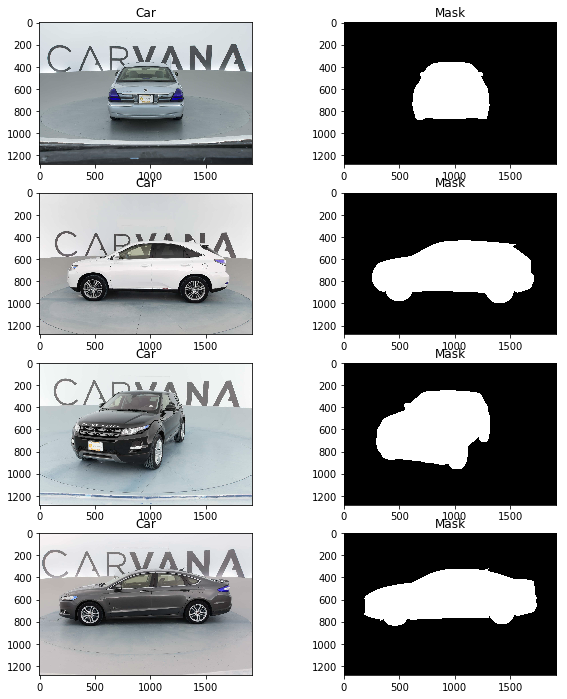

In [199]:
cwd = os.getcwd()
imgs_dir = '{}/train/'.format(cwd)
masks_dir = '{}/train_masks/'.format(cwd)

all_imgs = [x.split('.')[0] for x in os.listdir(imgs_dir) if x.endswith('.jpg')]

fig = plt.figure(figsize = (10,12))
#sample random images to display with their masks
indices = np.random.choice(np.arange(len(all_imgs)), (4))
for i, index in enumerate(indices):
    car =  all_imgs[index]
    img = cv2.imread('{}{}.jpg'.format(imgs_dir, car), 1)
    mask = Image.open('{}{}_mask.gif'.format(masks_dir, car))
    fig.add_subplot(4,2,2*i + 1)
    plt.imshow(img)
    plt.title('Car')
    fig.add_subplot(4,2,2*i + 2)
    plt.imshow(mask) 
    plt.title('Mask')

Resize the images to reduced the dimensionality of the input while keeping the same aspect ratio

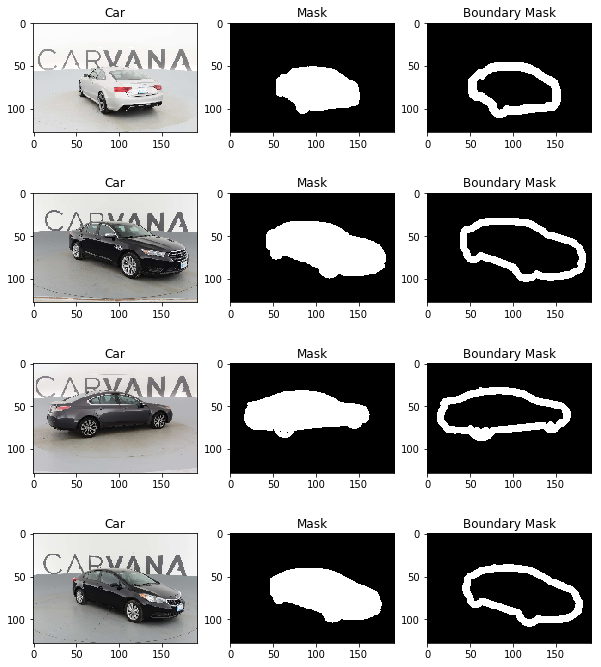

In [205]:
height, width = 1280, 1918
new_height, new_width = 128, 192

#intialize array to hold mask data
temp = np.zeros((height, width))
#create DataFrame to hold all images and masks
df = pd.DataFrame(data = np.zeros((len(all_imgs), 4), dtype = np.object), columns = ['FileName', 'Image', 'Mask', 'Grad'])
for index, file_name in enumerate(all_imgs):
    img = cv2.imread('{}{}.jpg'.format(imgs_dir, file_name), 1)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    temp[:,:] = Image.open('{}{}_mask.gif'.format(masks_dir, file_name))
    img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_CUBIC)
    mask = cv2.resize(temp, (new_width, new_height), interpolation = cv2.INTER_CUBIC)
    df.loc[index, 'FileName'] = file_name
    df.loc[index, 'Image'] = img
    df.loc[index, 'Mask'] = (mask > 0.5).astype(np.int32)
    df.loc[index, 'Grad'] = generate_grad_mask(mask)

height, width = new_height, new_width
#%% display car image, mask, boundary_mask
fig = plt.figure(figsize = (10,12))
#sample random images to display with their masks
indices = np.random.choice(np.arange(len(all_imgs)), (4))
for i, index in enumerate(indices):
    fig.add_subplot(4,3,3*i + 1)
    plt.imshow(df.loc[index, 'Image'])
    plt.title('Car')
    fig.add_subplot(4,3,3*i + 2)
    plt.imshow(df.loc[index, 'Mask'], cmap = 'gray')
    plt.title('Mask')
    fig.add_subplot(4,3,3*i + 3)
    plt.imshow(df.loc[index, 'Grad'], cmap = 'gray')
    plt.title('Boundary Mask')

Randomly splitting the data into training [4588 samples] and validation [ 500 samples]

In [3]:
#shuffle data
df = shuffle_DataFrame(df, seed = 9)
#splitting dataset into train and test sets
N = df.shape[0]
N_val = 500
N_tr = N - N_val

df_train = df.iloc[0: , :]
df_train.reset_index(drop = True, inplace = True)
df_val = df.iloc[N_tr:, :]
df_val.reset_index(drop = True, inplace = True)

### Setting up the Neural Network graph

In [3]:
#network paramters
n_channels = 3
l0_filters = 32
l1_filters = 64 
l2_filters = 128
l3_filters = 256
l4_filters = 512
l5_filters = 1024
drop_out = True
act_fcn = lambda x: tf.nn.leaky_relu(x, alpha = 0.25)

graph_unet = tf.Graph()
tf.reset_default_graph()
with graph_unet.as_default() as graph:    
    with tf.variable_scope('UNET', reuse = None) as scope_nn:
        X = tf.placeholder(shape = [None, height, width, n_channels], dtype = tf.float32, 
                           name = 'Input_Image')
        y = tf.placeholder(shape = [None, height, width], dtype = tf.float32, name = 'Mask')
        z = tf.placeholder(dtype = tf.float32, shape = [None, height, width], name = 'mask_grad')
        regularizer_lambda = tf.placeholder(shape = [], dtype = tf.float32)
        learning_rate = tf.placeholder(shape = [], dtype = tf.float32)
        keep_prob = tf.placeholder(shape = [], dtype = tf.float32)
        kernel_reg = tf.contrib.layers.l2_regularizer( scale = regularizer_lambda)
        training = tf.placeholder_with_default(False, shape = (), name = 'training')
 
        args = {'filter_shape': [3,3], 'kernel_reg': kernel_reg, 'activation': act_fcn, 
                'training': training, 'drop_out': drop_out, 'keep_prob': keep_prob, 
                'name': 'L1_1'}
        layer1_1 = create_conv_layer(X, n_filters = l1_filters, **args)  
        args.update(name = 'L1_2')
        layer1_2 = create_conv_layer(layer1_1, n_filters = l1_filters, **args) 
        layer1_pool = maxpool(layer1_2, name = 'Pool1')
        
        args.update(name = 'L2_1')
        layer2_1 = create_conv_layer(layer1_pool, n_filters = l2_filters, **args)
        args.update(name = 'L2_2')
        layer2_2 = create_conv_layer(layer2_1, n_filters = l2_filters, **args)
        layer2_pool = maxpool(layer2_2, name = 'Pool2')
        
        args.update(name = 'L3_1')
        layer3_1 = create_conv_layer(layer2_pool, n_filters = l3_filters, **args)
        args.update(name = 'L3_2')
        layer3_2 = create_conv_layer(layer3_1, n_filters = l3_filters, **args)
        layer3_pool = maxpool(layer3_2, name = 'pool3')
        
        args.update(name = 'L4_1')
        layer4_1 = create_conv_layer(layer3_pool, n_filters = l4_filters, **args)
        args.update(name = 'L4_2')
        layer4_2 = create_conv_layer(layer4_1, n_filters = l4_filters, **args)
        layer4_pool = maxpool(layer4_2, name = 'pool4')
        
        args.update(name = 'L5_1')
        layer5_1 = create_conv_layer(layer4_pool, n_filters = l5_filters, **args)
        args.update(name = 'L5_2')
        layer5_2 = create_conv_layer(layer5_1, n_filters = l5_filters, **args)
        
        #args for deconvolution part of unet
        args_deconv = {'filter_shape': [2,2], 'kernel_reg': kernel_reg,
                       'activation': act_fcn, 'training': training, 
                       'drop_out': drop_out, 'keep_prob': keep_prob,
                       'name': 'L6_deconv',}
        
        layer6_deconv = create_deconv_layer(layer5_2, n_filters = l4_filters, **args_deconv)
        args.update(name = 'L6_1')
        layer6_1 = create_conv_layer(tf.concat((layer6_deconv, layer4_2), axis = 3),
                                   n_filters = l4_filters, **args)
        args.update(name = 'L6_2')
        layer6_2 = create_conv_layer(layer6_1, n_filters = l4_filters, **args)
        
        args_deconv.update(name = 'L7_deconv')
        layer7_deconv = create_deconv_layer(layer6_2, n_filters = l3_filters, **args_deconv)
        args.update(name = 'L7_1')
        layer7_1 = create_conv_layer(tf.concat((layer7_deconv, layer3_2), axis = 3),
                                   n_filters = l3_filters, **args)
        args.update(name = 'L7_2')
        layer7_2 = create_conv_layer(layer7_1, n_filters = l3_filters, **args)

        args_deconv.update(name = 'L8_deconv')
        layer8_deconv = create_deconv_layer(layer7_2, n_filters = l2_filters, **args_deconv)
        args.update(name = 'L8_1')
        layer8_1 = create_conv_layer(tf.concat((layer8_deconv, layer2_2), axis = 3),
                                   n_filters = l2_filters, **args)

        args.update(name = 'L8_2')
        layer8_2 = create_conv_layer(layer8_1, n_filters = l2_filters, **args)
        
        args_deconv.update(name = 'L9_deconv')
        layer9_deconv = create_deconv_layer(layer8_2, n_filters = l1_filters, **args_deconv)
        args.update(name = 'L9_1')
        layer9_1 = create_conv_layer(tf.concat((layer9_deconv, layer1_2), axis = 3),
                                   n_filters = l1_filters, **args)        

        args.update(name = 'L9_2', activation = None)
        layer9_2 = create_conv_layer(layer9_1, n_filters = 1, **args)        
        
        prob = tf.nn.sigmoid(layer9_2, name = 'Probability')
        pred = tf.greater(prob, 0.5, name = 'Prediction')

        cross_entropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, 
                             logits = tf.squeeze(layer9_2, axis = 3), name = 'Cross_Entropy_Loss')  
        #weighting the loss according to the boundary mask
        weighted_loss = tf.reduce_mean(tf.multiply(cross_entropy_loss, 1+z, name = 'Weighted_Loss'))
        #to compute the regularization loss
        reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add(weighted_loss,regularizer_lambda*tf.reduce_sum(reg_loss),
                      name = 'Total_Loss')
        
        dice_coefficient = dice_coeff(tf.cast(tf.squeeze(pred, axis = 3), tf.float32), y)
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        training_ops = optimizer.minimize(loss)   
        merged_summary = tf.summary.merge_all()
        saver = tf.train.Saver(max_to_keep = 1000)
        init= tf.global_variables_initializer()


In [6]:
#paramter grid to use for drop out probability
keep_p = np.array([1, 0.8, 0.6])
n_epoches = 30
batch_size = 30
lr = 0.0001
n_batches = ceil(df_train.shape[0]/batch_size)
loss_train = np.zeros((len(keep_p), n_epoches))
dice_coeff_train = np.zeros((len(keep_p), n_epoches))
loss_val = np.zeros((len(keep_p), n_epoches))
dice_coeff_val = np.zeros((len(keep_p), n_epoches))
pred_dir = os.getcwd() + '/results/'
ensure_dir(pred_dir)

with tf.Session(graph = graph_unet) as sess:
    for i in range(len(keep_p)):
        tf.set_random_seed(10)
        sess.run(init)
        writer_dir = "{}parm_{}_graph".format(pred_dir, i)
        ensure_dir(writer_dir)
        writer = tf.summary.FileWriter(logdir = writer_dir, graph =sess.graph)
        for epoch in range(n_epoches):
            data = generate_batch(df_train, batch_size, seed = 0, shuffle = True)
            for batch in range(n_batches):
                batch_data = next(data)
                sess.run(training_ops, feed_dict = {X: batch_data[0],
                                                    y: batch_data[1],
                                                    z: batch_data[2],
                                                    learning_rate: lr,
                                                    training : True,
                                                    regularizer_lambda: 0,                    
                                                    keep_prob: keep_p[i]})
                
            #compute the loss and dice coeffs for train and validation sets                                               
            loss_train[i, epoch], dice_coeff_train[i, epoch] = evaluateLoss(df_train, epoch,
                                                                            batch_size, writer, 
                                                                            writer_dir)
            loss_val[i, epoch], dice_coeff_val[i, epoch] = evaluateLoss(df_val, epoch, 
                                                                        batch_size, writer, 
                                                                        writer_dir, 
                                                                        training = False)
            #saving the model to file
            saver.save(sess, '{}param_{}_epoch{}'.format(pred_dir, i, epoch))

### Visualizing and saving the cross validation results

Dice Coefficient train =  0.9899367739288312
Dice Coefficient validation =  0.9901024174690246
Best Keep Probability = 1.0, Best Epoch to stop training = 23


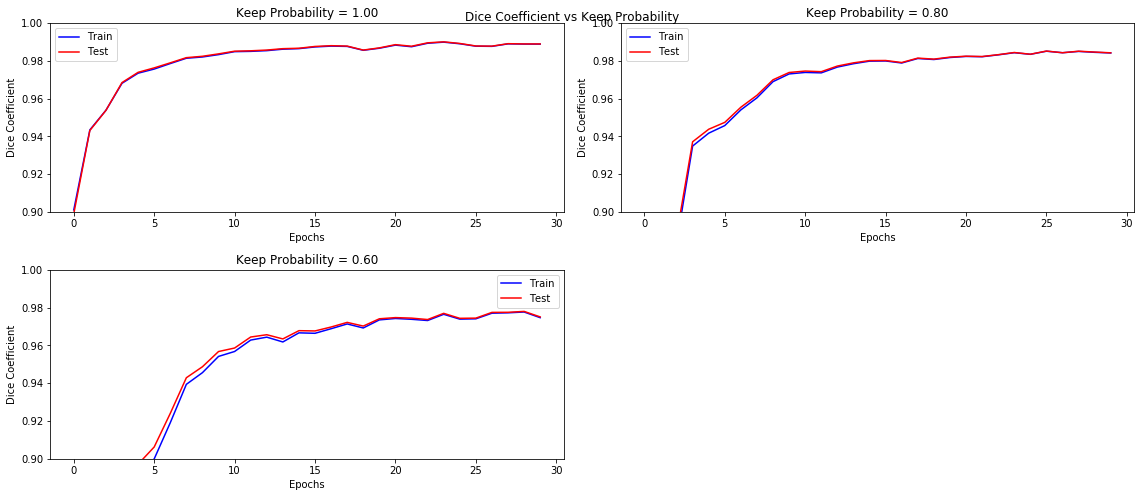

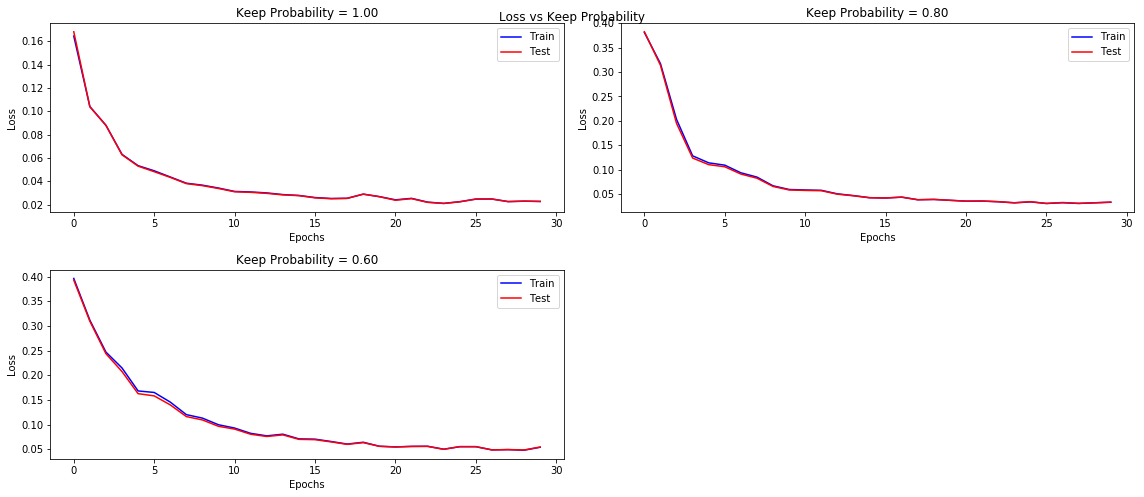

In [32]:
#best model is chosen based on early stopping criterion, where the best model is chosen as the first epoch in which
#the val Dice Coeff (rounded to 4 decimal digits) == max val Dice Coeff (rounded to 4 decimal digits)
best_param = np.argwhere(np.round(dice_coeff_val,4) == np.round(np.max(dice_coeff_val),4))[0, 0]
best_epoch = np.argwhere(np.round(dice_coeff_val[best_param,:],4) == np.round(np.max(dice_coeff_val[best_param,:]),4))[0,0]
#saving loss results to file
pd.DataFrame(loss_train).to_csv("loss_train.csv")
pd.DataFrame(loss_val).to_csv("loss_val.csv")
#saving Dice coefficients results to file
pd.DataFrame(dice_coeff_train).to_csv("dice_coeff_train.csv")
pd.DataFrame(dice_coeff_val).to_csv("dice_coeff_val.csv")

print('Dice Coefficient train = ', np.max(dice_coeff_train))
print('Dice Coefficient validation = ', np.max(dice_coeff_val))
print('Best Keep Probability = {}, Best Epoch to stop training = {}'.
      format(keep_p[best_param], best_epoch))

fig = plt.figure(figsize=(16, 10))
fig.suptitle("Dice Coefficient vs Keep Probability")
for i in range(len(keep_p)):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(dice_coeff_train[i,:], c = 'b')
    plt.hold
    ax.plot(dice_coeff_val[i,:], c= 'r')
    plt.ylim((0.9 , 1))
    ax.set_title('Keep Probability = {0:.2f}'.format(keep_p[i]))
    plt.legend(['Train', 'Test'])
    plt.ylabel('Dice Coefficient')  
    plt.xlabel('Epochs')  
    plt.tight_layout()

fig = plt.figure(figsize=(16, 10))   
fig.suptitle("Loss vs Keep Probability")
for i in range(len(keep_p)):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(loss_train[i,:], c = 'b')
    plt.hold
    ax.plot(loss_val[i,:], c= 'r')
    ax.set_title('Keep Probability = {0:.2f}'.format(keep_p[i]))
    plt.legend(['Train', 'Test'])
    plt.ylabel('Loss')  
    plt.xlabel('Epochs')  
    plt.tight_layout()

#### Also, Tensorboard can be used to check the results for active session, and to obtain more information about the weights and activation for each layer

![title](Tensorboard_coeffs.png)

![title](Tensorboard_histogram.png)

![title](Tensorboard_dist.png)

### Generate predictions for train and test sets

In [ ]:
#train predictions
df_pred = genrate_predictions(df_train, best_model)
#contcatenate prediction dataframe with original dataframe
df_train = pd.concat((df_train, df_pred), axis = 1)

#validation predictions
df_pred = genrate_predictions(df_val, best_model)
#contcatenate prediction dataframe with original dataframe
df_val = pd.concat((df_val, df_pred), axis = 1)

### Visualizing random predicted masks

#### Training set mask predictions

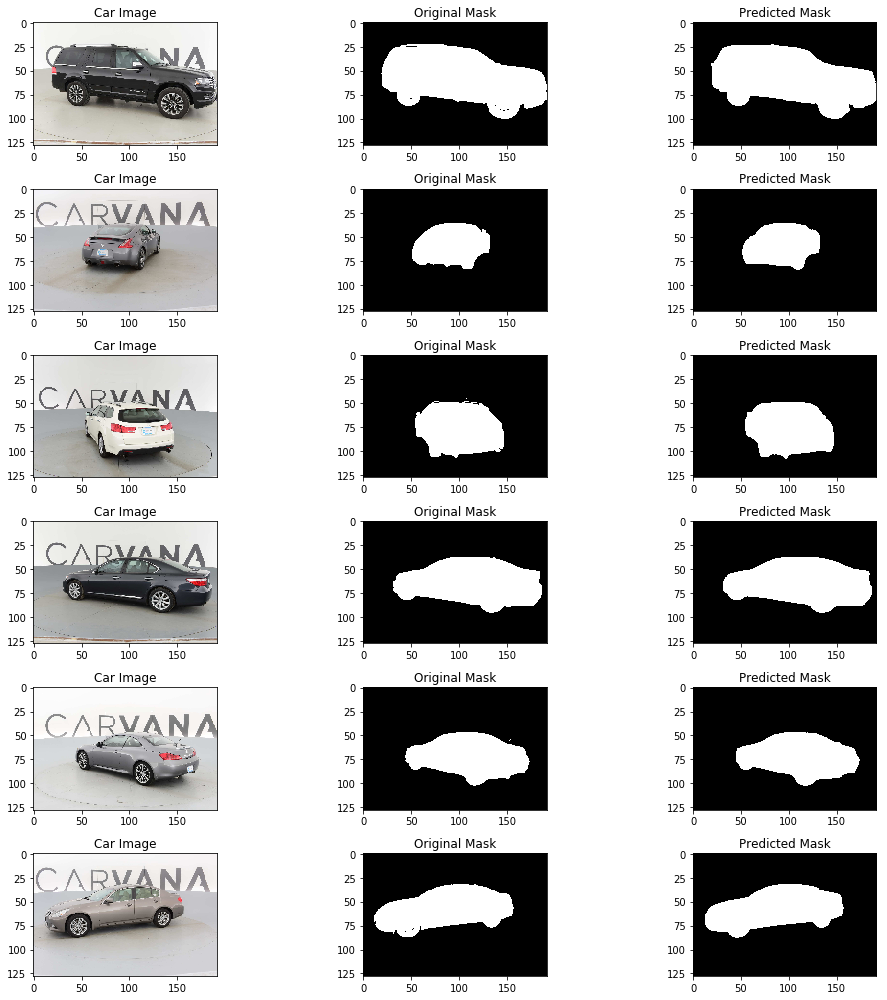

In [171]:
#%% display car image, mask, predicted_mask
fig = plt.figure(figsize = (16,14))
#sample random images to display with their masks
indices = np.random.choice(np.arange(len(df_train)), (6))
for i, index in enumerate(indices):
    fig.add_subplot(6,3,3*i + 1)
    plt.imshow(df_train.loc[index, 'Image'], label = 'car {}'.format(i+1))
    plt.title('Car Image')
    fig.add_subplot(6,3,3*i + 2)
    plt.imshow(df_train.loc[index, 'Mask'], label = 'mask {}'.format(i+1), cmap = 'gray')
    plt.title('Original Mask')
    fig.add_subplot(6,3,3*i + 3)
    plt.imshow(df_train.loc[index, 'Prediction'], label = 'mask {}'.format(i+1), cmap = 'gray')
    plt.title('Predicted Mask')
    plt.tight_layout()

#### Validation set mask predictions

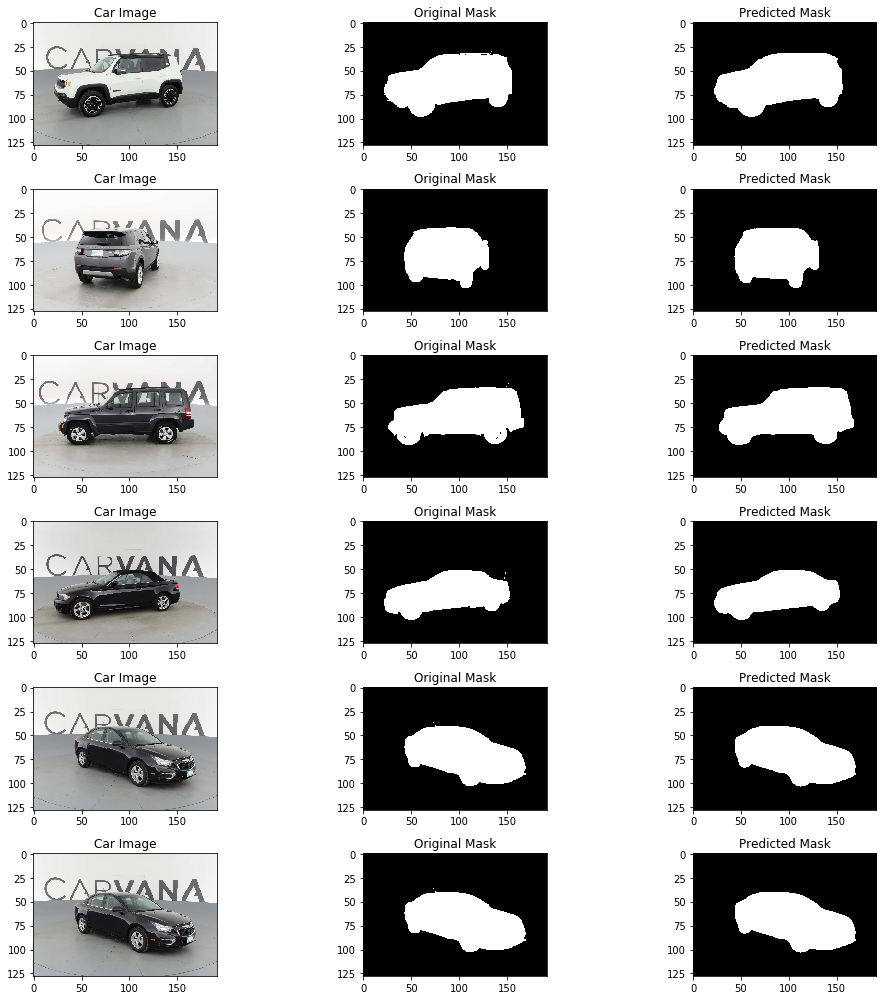

In [90]:
#%% display car image, mask, predicted_mask
fig = plt.figure(figsize = (16,14))
#sample random images to display with their masks
indices = np.random.choice(np.arange(len(df_val)), (6))
for i, index in enumerate(indices):
    fig.add_subplot(6,3,3*i + 1)
    plt.imshow(df_val.loc[index, 'Image'], label = 'car {}'.format(i+1))
    plt.title('Car Image')
    fig.add_subplot(6,3,3*i + 2)
    plt.imshow(df_val.loc[index, 'Mask'], label = 'mask {}'.format(i+1), cmap = 'gray')
    plt.title('Original Mask')
    fig.add_subplot(6,3,3*i + 3)
    plt.imshow(df_val.loc[index, 'Prediction'], label = 'mask {}'.format(i+1), cmap = 'gray')
    plt.title('Predicted Mask')
    plt.tight_layout()

### Conclusion

The best model was with keep probability of 1 [basically without drop out], and if we look at the loss 
results for training and validation, it can be noticed that the model variance is very small. So, there
is no need to reduce the model complexity via drop out.


### Future Work

The following ideas can be used to try to improve the model performance.
<br>1- Since the model has a low bias low variance, we can try to increase the model complixty by adding more filters and/or more layers.
<br>2- Data augmentation such as changing the colors and brightness, and use it for training
<br>3- Train the model with higher resolution images
